In [1]:
import numpy as np 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.datasets import mnist
import keras.backend as K
import matplotlib.pyplot as plt 

K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Load MNIST dataset. 
(x_train, y_train), (x_test, y_test) = mnist.load_data() 
x_train = x_train.astype('float32') / 255.0 
x_train = x_train.reshape((x_train.shape[0],) + (28, 28, 1)) 
print(x_train.shape) 

(60000, 28, 28, 1)


In [3]:
print(x_train.shape[0])
print(x_train.shape[3])
print(x_train.shape)

60000
1
(60000, 28, 28, 1)


In [4]:
class Gan : 
    def __init__(self, img_data) : 
         
        img_size = img_data.shape[1] # img 개수 
        channel = img_data.shape[3] if len(img_data.shape) >=4 else 1 # 흑백1, 컬러3 
        
        self.img_data = img_data
        self.input_shape = (img_size, img_size, channel) # 가로, 세로, 색
        
        self.img_rows = img_size
        self.img_cols = img_size
        self.channel = channel 
        self.noise_size = 100
        
        self.create_d()
        self.create_g()
        
        
        # Discriminator compile
        optimizer = adam(lr = 0.008)
        self.D.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        # Gan S compile G + D
        optimizer = adam(lr = 0.004)
        self.D.trainable = False
        self.S = Sequential()
        self.S.add(self.G)
        self.S.add(self.D)
        self.S.compile(loss='binary_crossentropy', optimizer = optimizer)
        self.S.summary()
            
    def create_g(self) : 
        self.G = Sequential()
        depth = 64 + 64 + 64 + 64
        dropout = 0.4
        dim = 7 
        self.G.add(Dense(dim * dim * depth, input_dim=self.noise_size)) 
        self.G.add(Activation(LeakyReLU(0.2)))
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Reshape((dim, dim, depth))) 
        self.G.add(UpSampling2D())
        
        self.G.add(Conv2D(int(depth/2), kernel_size=5, padding='same'))
        self.G.add(Activation(LeakyReLU(0.2)))
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(UpSampling2D()) 
        
        self.G.add(Conv2D(int(depth/4), kernel_size=5, padding='same'))
        self.G.add(Activation(LeakyReLU(0.2)))
        self.G.add(BatchNormalization(momentum=0.9)) 
        
        self.G.add(Conv2D(int(depth/8), kernel_size=5, padding='same'))
        self.G.add(Activation(LeakyReLU(0.2)))
        self.G.add(BatchNormalization(momentum=0.9))   
        
        self.G.add(Conv2D(1, 5, padding='same'))
        self.D.add(Activation('sigmoid'))
        self.G.summary() 
        return self.G
    
    def create_d(self) : 
        self.D = Sequential()
        depth = 64
        dropout = 0.4 
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=self.input_shape, padding='same'))
        self.D.add(Activation(LeakyReLU(0.2)))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(Activation(LeakyReLU(0.2)))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(Activation(LeakyReLU(0.2)))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*8, 5, strides=2, padding='same'))
        self.D.add(Activation(LeakyReLU(0.2)))
        self.D.add(Dropout(dropout))
        
        self.D.add(Flatten())
        self.D.add(Dense(1, activation='sigmoid'))
        self.D.summary()
        return self.D

    def train(self, batch_size=100): 
        # Pick image data randomly. 
        images_train = self.img_data[np.random.randint(0, self.img_data.shape[0], size=batch_size), :, :, :] 
        
        # Generate images from noise. 
        # noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
        noise = np.random.normal(0, 1, size=[batch_size, self.noise_size])
        images_fake = self.G.predict(noise) 
        
        
        # Train D. 
        x = np.concatenate((images_train, images_fake)) # 배열결합 
        y = np.ones([2 * batch_size, 1]) 
        y[batch_size: , : ] = 0 
        self.D.trainable = False # 학습 방지
        d_loss = self.D.train_on_batch(x, y) 
        
        # Train G. 
        y = np.ones([batch_size, 1]) 
        # noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
        noise = np.random.normal(0, 1, size=[batch_size, self.noise_size])
        self.D.trainable = False # 학습방지
        a_loss = self.S.train_on_batch(noise, y) 
        
        return d_loss, a_loss, images_fake
    
    def save(self) : 
        self.G.save_weights('gan_g_wight.h5')
        self.D.save_weights('gan_d_wight.h5')
        
    #def load(self) : 
        

In [5]:
# Init network 
gan = Gan(x_train) 

# Some parameters. 
epochs = 30 
sample_size = 10 
batch_size = 100 
train_per_epoch = x_train.shape[0] // batch_size



/home/hiwony/.local/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)        

Epoch: 1


/home/hiwony/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/hiwony/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Loss: 0.8114206555485726, S Loss: 0.3157616376876831


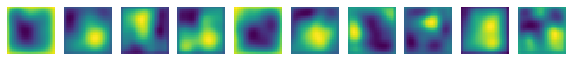

Epoch: 2
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


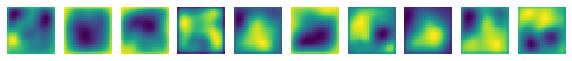

Epoch: 3
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


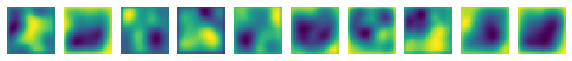

Epoch: 4
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


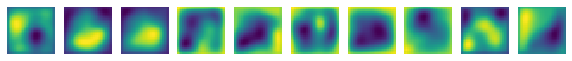

Epoch: 5
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


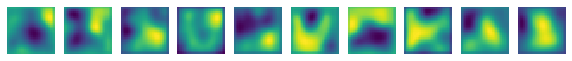

Epoch: 6
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


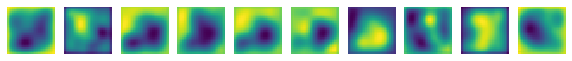

Epoch: 7
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


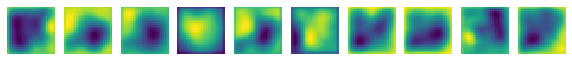

Epoch: 8
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


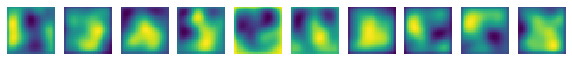

Epoch: 9
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


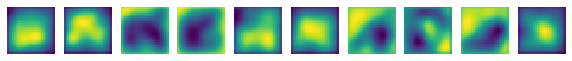

Epoch: 10
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


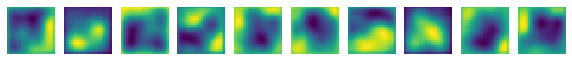

Epoch: 11
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


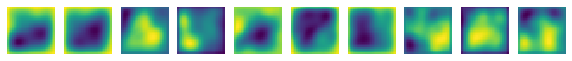

Epoch: 12
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


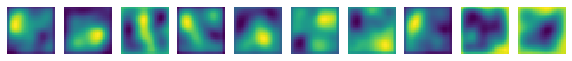

Epoch: 13
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


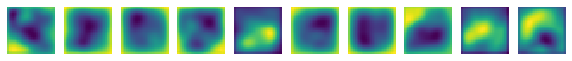

Epoch: 14
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


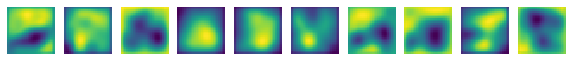

Epoch: 15
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


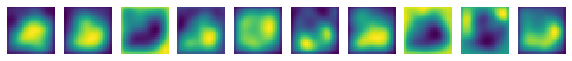

Epoch: 16
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


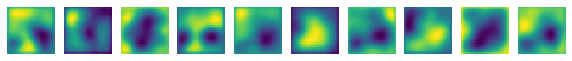

Epoch: 17
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


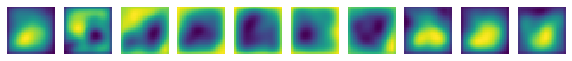

Epoch: 18
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


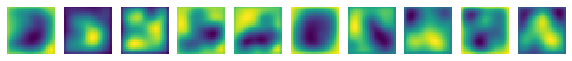

Epoch: 19
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


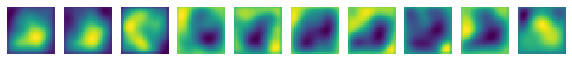

Epoch: 20
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


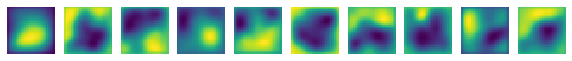

Epoch: 21
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


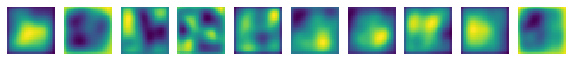

Epoch: 22
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


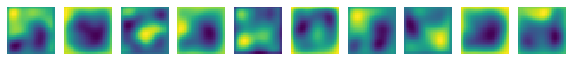

Epoch: 23
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


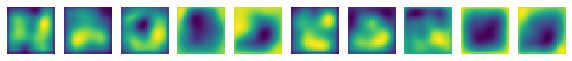

Epoch: 24
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


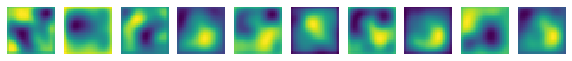

Epoch: 25
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


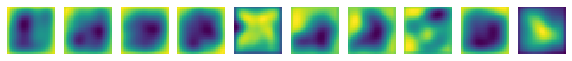

Epoch: 26
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


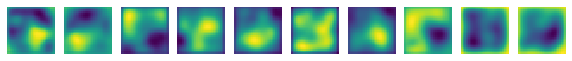

Epoch: 27
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


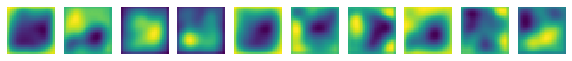

Epoch: 28
D Loss: 0.8132616281509399, S Loss: 0.3132616877555847


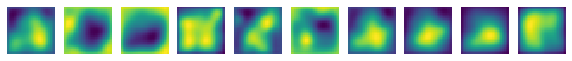

Epoch: 29


KeyboardInterrupt: 

In [6]:
for epoch in range(0, epochs): 
    print("Epoch:", epoch + 1) 
    total_d_loss = 0.0 
    total_a_loss = 0.0 
    for batch in range(0, train_per_epoch): 
        d_loss, a_loss, imgs = gan.train(batch_size) 
        total_d_loss += d_loss 
        total_a_loss += a_loss 
        
    total_d_loss /= train_per_epoch 
    total_a_loss /= train_per_epoch 
    
    print("D Loss: {}, S Loss: {}".format(total_d_loss, total_a_loss)) 
    
    # Show generated images. 
    fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1)) 
    for i in range(0, sample_size): 
        ax[i].set_axis_off() 
        ax[i].imshow(imgs[i].reshape((28, 28))) 
    
    plt.show() 
    plt.close(fig)
